<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-04-18 10:36:34--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-04-18 10:36:34--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-04-18 10:36:35--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

['jimi-hendrix.txt',
 'eminem.txt',
 'al-green.txt',
 'bjork.txt',
 'Lil_Wayne.txt',
 'notorious-big.txt',
 'michael-jackson.txt',
 'rihanna.txt',
 'alicia-keys.txt',
 'radiohead.txt',
 'blink-182.txt',
 'disney.txt',
 'nursery_rhymes.txt',
 'patti-smith.txt',
 'amy-winehouse.txt',
 'bruno-mars.txt',
 'drake.txt',
 'bieber.txt',
 'dr-seuss.txt',
 'nicki-minaj.txt',
 'johnny-cash.txt',
 'leonard-cohen.txt',
 'britney-spears.txt',
 'lady-gaga.txt',
 'dj-khaled.txt',
 'bob-dylan.txt',
 'notorious_big.txt',
 'missy-elliott.txt',
 'janisjoplin.txt',
 'dickinson.txt',
 'adele.txt',
 'beatles.txt',
 'Kanye_West.txt',
 'joni-mitchell.txt',
 'r-kelly.txt',
 'dolly-parton.txt',
 'kanye.txt',
 'nirvana.txt',
 'lil-wayne.txt',
 'kanye-west.txt',
 'bruce-springsteen.txt',
 'paul-simon.txt',
 'nickelback.txt',
 'cake.txt',
 'lin-manuel-miranda.txt',
 'ludacris.txt',
 'lorde.txt',
 'bob-marley.txt',
 'prince.txt']

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-4-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 29., 305., 221., 523., 293.,  72., 180.,  97.,  42.,  39.,  22.,
         12.,   4.,   3.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([ 1.  ,  2.65,  4.3 ,  5.95,  7.6 ,  9.25, 10.9 , 12.55, 14.2 ,
        15.85, 17.5 , 19.15, 20.8 , 22.45, 24.1 , 25.75, 27.4 , 29.05,
        30.7 , 32.35, 34.  ]),
 <BarContainer object of 20 artists>)

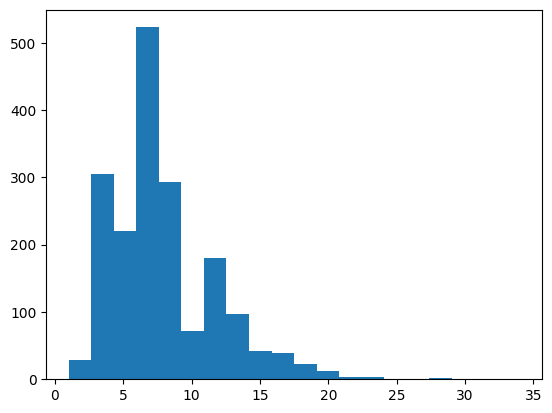

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences

[[200, 10, 12, 907, 908, 42, 909, 121],
 [22, 13, 638, 91, 217, 349, 79, 4, 314],
 [23, 2, 160, 9, 200, 520, 35, 83, 910, 3, 78, 2, 911, 4, 15],
 [173, 7, 912, 913, 397, 8],
 [23, 200, 218, 520, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200],
 [175,
  175,
  175,
  175,
  175,
  175,
  175,
  36,
  2,
  230,
  522,
  9,
  398,
  17,
  914,
  639,
  640,
  133,
  4,
  8],
 [447, 162, 17, 315, 29, 13, 15],
 [5, 9, 12, 915, 17, 916, 19, 20, 189, 74, 9, 917, 17, 8],
 [447, 162, 17, 315, 29, 13, 15],
 [29, 13, 15, 29, 13, 15, 29, 13, 15, 29, 13, 15],
 [448, 162, 17, 315, 29, 13, 15, 5, 36, 3, 399, 918, 107, 3

In [ ]:
max_context_size+1

13

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

1957

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(15325, 13)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'so': 61, 'troubles': 1, 'my': 134, 'seemed': 1, 'away': 21, 'yesterday': 10, 'all': 177, 'far': 1, 'it': 125, 'to': 307, 'stay': 7, 'as': 25, 'looks': 2, 'here': 33, "they're": 5, 'though': 11, 'now': 90, 'the': 376, 'believe': 15, 'man': 34, 'in': 186, 'not': 32, 'half': 1, 'oh': 77, 'used': 1, 'suddenly': 3, 'be': 108, 'i': 400, "i'm": 66, 'hanging': 1, 'shadow': 1, 'a': 270, 'me': 219, "there's": 14, 'over': 5, 'go': 38, 'say': 76, "don't": 74, 'why': 20, 'know': 132, "wouldn't": 4, 'she': 90, 'came': 11, 'had': 19, 'was': 48, 'play': 10, 'long': 25, 'something': 13, 'wrong': 6, 'an': 15, 'said': 14, 'game': 3, 'such': 9, 'love': 181, 'easy': 9, 'for': 62, 'need': 51, 'hide': 13, 'place': 10, 'when': 71, 'of': 109, 'mary': 2, 'trouble': 1, 'mother': 2, 'find': 10, 'times': 5, 'comes': 20, 'myself': 3, 'mm': 3, 'let': 55, 'speaking': 4, 'wisdom': 7, 'words': 14, 'standing': 13, 'and': 311, 'front': 1, 'darkness': 1, 'is': 89, 'hour': 1, 'right': 25, 'whis


### Definir el modelo

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 5)             8145      
                                                                 
 lstm (LSTM)                 (None, 12, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1629)              53757     
                                                                 
Total params: 114926 (448.93 KB)
Trainable params: 11492

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:

          # armamos todas las subsecuencias
          subseq = [seq[:i] for i in range(len(seq))]
          target = [seq[i] for i in range(len(seq))]
          bb = pad_sequences(subseq, maxlen=max_context_size, padding='pre')

          # utilizamos el modelo para que haga su predicción en cada subsecuencia
          # (son las probabilidades condicionadas)
          predictions = self.model.predict(bb,verbose=0)

          # en `probs`iremos guardando las probabilidades de los términos target
          probs = []

          for idx_seq, idx_vocab in enumerate(target):
              probs.append(predictions[idx_seq,idx_vocab])

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/len(target)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=1024)

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 7.3801
 mean perplexity: 1545.5415156206486 

15/15 [==============================] - 44s 2s/step - loss: 7.3801
Epoch 2/50
14/15 [===========================>..] - ETA: 0s - loss: 7.0122
 mean perplexity: 808.5302995920806 

15/15 [==============================] - 25s 2s/step - loss: 6.9737
Epoch 3/50
11/15 [=====================>........] - ETA: 0s - loss: 6.0287
 mean perplexity: 1492.3989246001738 

15/15 [==============================] - 22s 2s/step - loss: 5.9813
Epoch 4/50
14/15 [===========================>..] - ETA: 0s - loss: 5.7582
 mean perplexity: 1750.1124059010174 

15/15 [==============================] - 23s 2s/step - loss: 5.7625
Epoch 5/50
14/15 [===========================>..] - ETA: 0s - loss: 5.7263

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
#sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()


### Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=2)

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times")

In [ ]:
# veamos las salidas
decode(salidas[0])

### Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

## Consignas del desafío

1-Entrenar un modelo de lenguaje basado en arquitectura recurrente, utilizando un corpus mayor al utilizado en clase.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# Descargar la carpeta de dataset
import os
import platform
import zipfile

if os.access('spa-sparvg.txt', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https: // raw.githubusercontent.com/BibleNLP/ebible/main/corpus/spa-spavbl.txt - o spa-sparvg.txt
    else:
        !wget spa-sparvg.txt https: // raw.githubusercontent.com/BibleNLP/ebible/main/corpus/spa-spavbl.txt
else:
    print("El dataset ya se encuentra descargado")

--2024-04-18 19:48:31--  http://spa-sparvg.txt/
Resolving spa-sparvg.txt (spa-sparvg.txt)... failed: Name or service not known.
wget: unable to resolve host address ‘spa-sparvg.txt’
--2024-04-18 19:48:31--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
//: Scheme missing.
--2024-04-18 19:48:31--  http://raw.githubusercontent.com/BibleNLP/ebible/main/corpus/spa-spavbl.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/BibleNLP/ebible/main/corpus/spa-spavbl.txt [following]
--2024-04-18 19:48:31--  https://raw.githubusercontent.com/BibleNLP/ebible/main/corpus/spa-spavbl.txt
Connecting to raw.githubusercontent.com 

In [3]:
import pandas as pd

bible_df = pd.read_csv('./spa-spavbl.txt', sep='/n',
                       quotechar='"', header=None, engine='python')
bible_df.head()

,0
0,"En el principio, Dios creó los cielos y la tie..."
1,La tierra carecía de forma y estaba vacía; la ...
2,Y Dios dijo: “¡Que haya luz!” y hubo luz.
3,"Dios vio que la luz era buena, y separó a la l..."
4,Entonces Dios llamó a la luz “día” y a la oscu...


In [4]:
print("Cantidad de documentos:", bible_df.shape[0])

Cantidad de documentos: 31081


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [6]:
bible_sentences = list(bible_df.loc[:,0])
bible_sentences

['En el principio, Dios creó los cielos y la tierra.',
 'La tierra carecía de forma y estaba vacía; la oscuridad cubría la superficie del abismo y el Espíritu de Dios se movía sobre la superficie de las aguas.',
 'Y Dios dijo: “¡Que haya luz!” y hubo luz.',
 'Dios vio que la luz era buena, y separó a la luz de la oscuridad.',
 'Entonces Dios llamó a la luz “día” y a la oscuridad le llamó “noche”. Así que hubo noche y mañana, lo cual fue el primer día.',
 'Entonces Dios dijo: “Que haya expansión en medio de las aguas para dividirlas”.',
 'Así que Dios hizo una expansión para separar las aguas que estaban arriba de las aguas, de las aguas que estaban debajo. Y así sucedió.',
 'Dios llamó a la expansión “cielo”.Entonces hubo noche y mañana, lo cual fue el segundo día.',
 'Dios dijo: “Que las aguas que están debajo del cielo se junten en un solo lugar para que aparezca la tierra”.Y así sucedió.',
 'Entonces Dios llamó al suelo “tierra” y a las aguas les llamó “mares”.Y Dios vio que era bue

In [7]:
segmented_sentences = [text_to_word_sequence(sentence) for sentence in bible_sentences]
length_sentences = [len(sentence) for sentence in segmented_sentences]

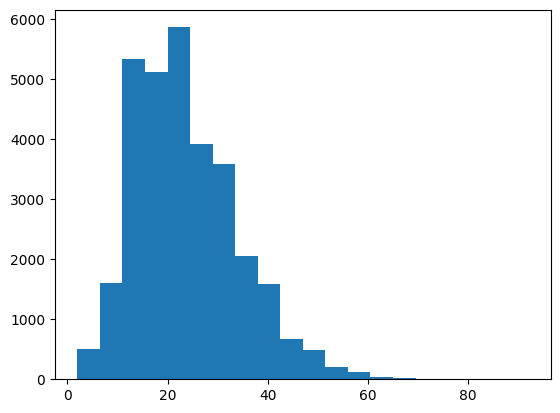

In [8]:
plt.hist(length_sentences, bins=20);

In [9]:
max_context_size = int(np.percentile(length_sentences, 90)-1)
print(f'max_context_size (percentile 0.9): {max_context_size}')

max_context_size (percentile 0.9): 37


In [10]:
bible_tokenizer = Tokenizer()

bible_tokenizer.fit_on_texts(segmented_sentences)
tokenized_sentences = bible_tokenizer.texts_to_sequences(segmented_sentences)

In [11]:
vocab_size = len(bible_tokenizer.word_counts)

In [12]:
 %pprint

Pretty printing has been turned OFF


In [13]:
tokenized_sentences[1:6]

[[6, 50, 12842, 1, 456, 2, 75, 4533, 6, 642, 5227, 6, 3115, 14, 4264, 2, 4, 171, 1, 23, 9, 8777, 53, 6, 3115, 1, 17, 571], [2, 23, 40, 2166, 395, 254, 48, 2, 896, 254], [23, 298, 3, 6, 254, 76, 292, 2, 6771, 5, 6, 254, 1, 6, 642], [35, 23, 371, 5, 6, 254, 17520, 2, 5, 6, 642, 26, 371, 17521, 44, 3, 896, 194, 2, 310, 12, 478, 57, 4, 486, 66], [35, 23, 40, 1037, 395, 8778, 8, 191, 1, 17, 571, 15, 17522]]

In [14]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = \
  train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [15]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [16]:
print(f'Original amount of sentences: {len(tokenized_sentences_train)}/Splitted sentences:{len(tok_sent)}')

Original amount of sentences: 24864/Splitted sentences:40226


In [17]:
#Aumentación del train set por generación de secuencias
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [18]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [19]:
print(f'# augmented sentences: {train_seqs.shape[0]}')

# augmented sentences: 1111563


In [20]:
tok_sents_val = []

for sent in tokenized_sentences_val:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sents_val.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sents_val.append(sent)

tok_sents_val_pad = []
tok_sents_val_pad.append(pad_sequences(tok_sents_val, maxlen=max_context_size+1, padding='pre'))
valid_seqs = np.concatenate(tok_sents_val_pad, axis=0)

In [21]:
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

X_val = valid_seqs[:,:-1]
y_val = valid_seqs[:,-1]

In [22]:
 %pprint

Pretty printing has been turned ON


In [23]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(bible_tokenizer.word_index)

{'de': 1, 'y': 2, 'que': 3, 'el': 4, 'a': 5, 'la': 6, 'los': 7, 'en': 8, 'se': 9, 'no': 10, 'señor': 11, 'lo': 12, 'su': 13, 'del': 14, 'para': 15, 'con': 16, 'las': 17, 'por': 18, 'un': 19, 'sus': 20, 'al': 21, 'como': 22, 'dios': 23, 'es': 24, 'una': 25, 'le': 26, 'pero': 27, 'me': 28, 'él': 29, 'tu': 30, 'porque': 31, 'mi': 32, 'cuando': 33, 'todos': 34, 'entonces': 35, 'te': 36, 'rey': 37, 'todo': 38, 'les': 39, 'dijo': 40, 'ellos': 41, 'hijo': 42, 'ustedes': 43, 'así': 44, 'si': 45, 'ha': 46, 'pueblo': 47, '”': 48, 'había': 49, 'tierra': 50, 'yo': 51, 'israel': 52, 'sobre': 53, 'más': 54, 'esto': 55, 'hijos': 56, 'fue': 57, 'son': 58, 'jesús': 59, 'hasta': 60, 'tus': 61, 'este': 62, 'o': 63, 'hombre': 64, 'está': 65, 'día': 66, 'también': 67, 'han': 68, 'allí': 69, 'padre': 70, 'ser': 71, 'david': 72, 'hecho': 73, 'ni': 74, 'estaba': 75, 'era': 76, 'he': 77, 'ciudad': 78, 'sin': 79, 'esta': 80, 'desde': 81, 'todas': 82, 'casa': 83, 'dice': 84, 'ti': 85, 'contra': 86, 'nos': 87, 'm

In [24]:
print(bible_tokenizer.word_docs)

defaultdict(<class 'int'>, {'principio': 78, 'tierra': 1648, 'y': 18517, 'la': 11786, 'creó': 32, 'en': 10381, 'el': 14471, 'cielos': 185, 'dios': 4049, 'los': 11246, 'forma': 153, 'del': 5299, 'estaba': 887, 'las': 4867, 'carecía': 2, 'vacía': 11, 'superficie': 16, 'espíritu': 412, 'se': 7056, 'aguas': 123, 'oscuridad': 100, 'abismo': 11, 'movía': 4, 'cubría': 9, 'sobre': 1416, 'de': 19412, '”': 1690, 'dijo': 2123, '“¡que': 28, 'haya': 169, 'hubo': 72, 'luz': 277, 'separó': 6, 'buena': 255, 'a': 14046, 'que': 16440, 'vio': 254, 'era': 876, 'primer': 137, '“día”': 1, 'día': 1060, 'cual': 150, 'le': 3171, 'fue': 1309, 'noche': 380, '“noche”': 1, 'llamó': 191, 'lo': 5985, 'mañana': 233, 'entonces': 2581, 'así': 2015, 'dividirlas”': 1, '“que': 64, 'medio': 379, 'para': 5494, 'expansión': 4, 'estaban': 697, 'una': 3323, 'arriba': 55, 'separar': 5, 'debajo': 57, 'sucedió': 129, 'hizo': 766, 'segundo': 126, '“cielo”': 1, 'un': 4581, 'lugar': 689, 'están': 778, 'solo': 424, 'cielo': 443, 'jun

2-Explorar diferentes variantes de arquitecturas (GRU, LSTM, Bidireccionales, Cantidad de capas y neuronas, tamaño de contexto máximo)
El objetivo principal sería lograr que durante el entrenamiento baje la perplejidad.

**Definición de utilidades de entrenamiento**

In [25]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.8 MB/s eta 0:00:00


In [26]:
from torcheval.metrics import Perplexity
import torch

class ModifiedPplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, X_val, y_val):
      self.X_val, self.y_val = X_val, y_val
      self.metric = Perplexity(device='cuda:0')
      self.history = []

    def on_epoch_end(self, epoch, logs=None):
      predictions = self.model.predict(self.X_val, verbose=0)

      input = torch.tensor(np.array([predictions]))
      target = torch.tensor(np.array([self.y_val]))

      self.metric.reset()
      self.metric.update(input, target)
      perplexity = self.metric.compute()

      self.history.append(perplexity.cpu())

      print(f'\n Mean perplexity: {perplexity} \n')

In [27]:
from keras import backend as K

BATCH_SIZE = 40980

def trainModel(model, lr=0.0003, epochs=50):
  K.set_value(model.optimizer.learning_rate, lr)
  pplCallback = ModifiedPplCallback(X_val, y_val)
  hist = model.fit(X, y, epochs=epochs, callbacks=[pplCallback], \
                  validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

  return hist.history, pplCallback.history

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def showResults(history, pplHistory):
  epoch_count = range(1, len(history['loss']) + 1)

  sns.lineplot(x=epoch_count,  y=history['loss'], label='train')
  sns.lineplot(x=epoch_count,  y=history['val_loss'], label='valid')
  plt.show()

  sns.lineplot(x=epoch_count,  y=torch.tensor(pplHistory).cpu(), label='perplexity')
  plt.show()

**Modelo 1**

In [ ]:
model1 = Sequential()

model1.add(Embedding(input_dim=max_context_size+1,
                     output_dim=4, input_shape=(max_context_size,)))

model1.add(LSTM(units=6, return_sequences=True))
model1.add(Dropout(0.5))
model1.add(LSTM(units=4, return_sequences=True))
model1.add(Dropout(0.5))
model1.add(LSTM(units=3))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(vocab_size+1, activation='softmax'))

model1.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 37, 4)             152       
                                                                 
 lstm_6 (LSTM)               (None, 37, 6)             264       
                                                                 
 dropout_8 (Dropout)         (None, 37, 6)             0         
                                                                 
 lstm_7 (LSTM)               (None, 37, 4)             176       
                                                                 
 dropout_9 (Dropout)         (None, 37, 4)             0         
                                                                 
 lstm_8 (LSTM)               (None, 3)                 96        
                                                                 
 dropout_10 (Dropout)        (None, 3)                

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 10.1880
 Mean perplexity: 31653.194099323387 

28/28 [==============================] - 13s 484ms/step - loss: 10.1880 - val_loss: 10.1969
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 10.1090
 Mean perplexity: 31653.194099323387 

28/28 [==============================] - 13s 485ms/step - loss: 10.1090 - val_loss: 10.1301
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 10.0234
 Mean perplexity: 31653.209949763477 

28/28 [==============================] - 13s 478ms/step - loss: 10.0234 - val_loss: 10.0568
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 9.9340
 Mean perplexity: 31653.217874986472 

28/28 [==============================] - 15s 544ms/step - loss: 9.9340 - val_loss: 9.9805
Epoch 5/100
28/28 [==============================] - ETA: 0s - loss: 9.8412
 Mean perplexity: 31653.189344192906 

28/28 [==============================] - 15s 537ms/step 

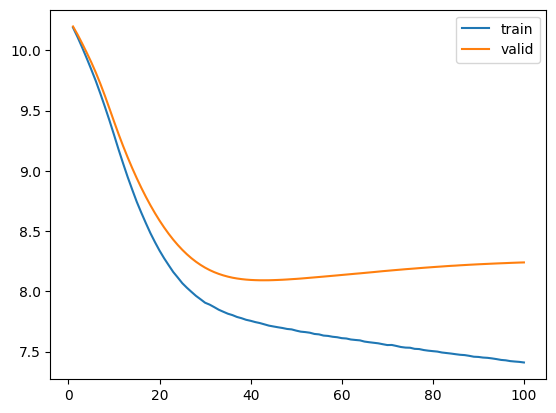

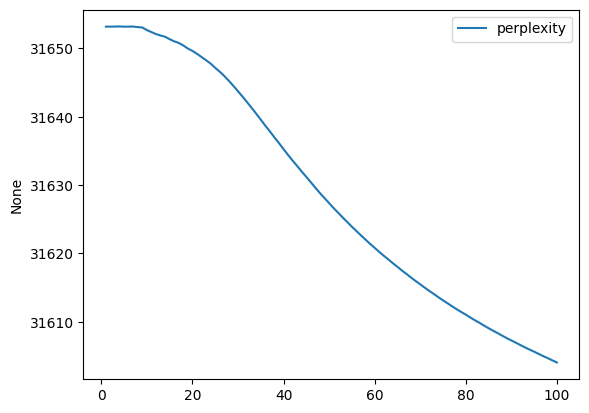

In [ ]:
history, pplHistory = trainModel(model1, lr=0.0003, epochs=100)
showResults(history, pplHistory)

**Modelo 2**

In [ ]:
from keras.layers import Bidirectional

model2 = Sequential()

embedding_out_dim = 6
model2.add(Embedding(input_dim=max_context_size+1,
                     output_dim=embedding_out_dim, input_shape=(max_context_size,)))

input_shape=(X[0].shape, embedding_out_dim)

model2.add(Bidirectional(LSTM(16, activation='relu'), input_shape=input_shape))
model2.add(Dropout(0.5))
model2.add(Dense(vocab_size+1, activation='softmax'))

model2.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 6)             228       
                                                                 
 bidirectional (Bidirection  (None, 32)                2944      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 31653)             1044549   
                                                                 
Total params: 1047721 (4.00 MB)
Trainable params: 1047721 (4.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 10.3352
 Mean perplexity: 31653.0752212758 

28/28 [==============================] - 26s 956ms/step - loss: 10.3352 - val_loss: 10.3268
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 10.2769
 Mean perplexity: 31653.098996849647 

28/28 [==============================] - 24s 879ms/step - loss: 10.2769 - val_loss: 10.2391
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 9.3385
 Mean perplexity: 31640.643042944666 

28/28 [==============================] - 24s 877ms/step - loss: 9.3385 - val_loss: 9.0809
Epoch 4/20
28/28 [==============================] - ETA: 0s - loss: 7.1762
 Mean perplexity: 31596.848457506603 

28/28 [==============================] - 19s 676ms/step - loss: 7.1762 - val_loss: 8.3650
Epoch 5/20
28/28 [==============================] - ETA: 0s - loss: 6.8948
 Mean perplexity: 31542.308920348776 

28/28 [==============================] - 18s 648ms/step - loss: 6.

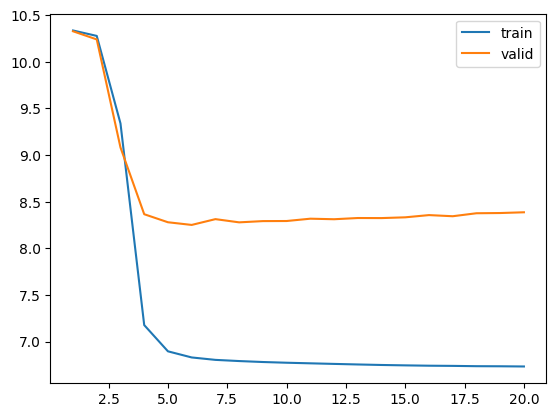

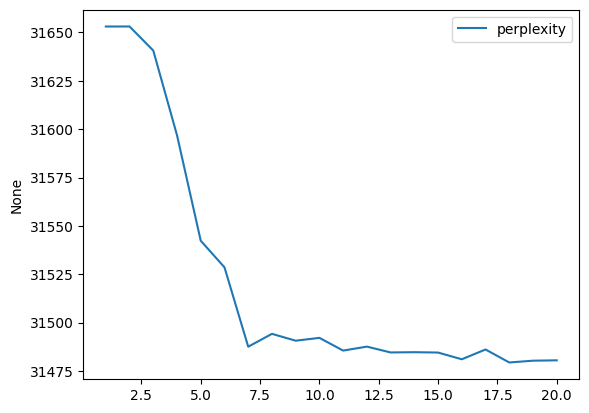

In [ ]:
history, pplHistory = trainModel(model2, lr=0.0003, epochs=20)
showResults(history, pplHistory)

**Modelo 3**

In [ ]:
from keras.layers import GRU

model3 = Sequential()

embedding_out_dim = 6
model3.add(Embedding(input_dim=max_context_size+1,
                     output_dim=embedding_out_dim, input_shape=(max_context_size,)))

model3.add(GRU(units=6))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(vocab_size+1, activation='softmax'))

model3.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 37, 6)             228       
                                                                 
 gru_5 (GRU)                 (None, 6)                 252       
                                                                 
 dropout_23 (Dropout)        (None, 6)                 0         
                                                                 
 dense_15 (Dense)            (None, 4)                 28        
                                                                 
 dropout_24 (Dropout)        (None, 4)                 0         
                                                                 
 dense_16 (Dense)            (None, 31653)             158265    
                                                                 
Total params: 158773 (620.21 KB)
Trainable params: 15

Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 7.6863
 Mean perplexity: 31597.98767794446 

28/28 [==============================] - 13s 476ms/step - loss: 7.6863 - val_loss: 8.1020
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 7.6758
 Mean perplexity: 31596.74165769637 

28/28 [==============================] - 12s 450ms/step - loss: 7.6758 - val_loss: 8.0991
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 7.6609
 Mean perplexity: 31595.566883608957 

28/28 [==============================] - 12s 455ms/step - loss: 7.6609 - val_loss: 8.0982
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 7.6480
 Mean perplexity: 31594.47521351105 

28/28 [==============================] - 12s 447ms/step - loss: 7.6480 - val_loss: 8.0991
Epoch 5/50
28/28 [==============================] - ETA: 0s - loss: 7.6350
 Mean perplexity: 31593.454773398193 

28/28 [==============================] - 12s 456ms/step - loss: 7.6350 - 

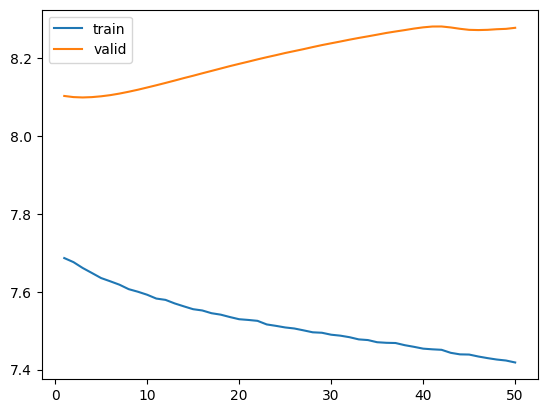

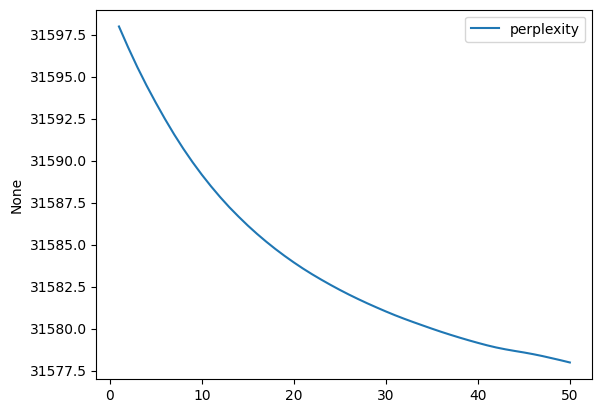

In [ ]:
history, pplHistory = trainModel(model3, lr=0.0003, epochs=50)
showResults(history, pplHistory)

**Modelo 4**

In [ ]:
from keras.layers import GRU

model4 = Sequential()

embedding_out_dim = 8
model4.add(Embedding(input_dim=max_context_size+1,
                     output_dim=embedding_out_dim, input_shape=(max_context_size,)))

model4.add(GRU(units=32, return_sequences=True))
model4.add(Dropout(0.5))
model4.add(GRU(units=16))
model4.add(Dropout(0.5))
model4.add(Dense(4, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(vocab_size+1, activation='softmax'))

model4.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 8)             304       
                                                                 
 gru (GRU)                   (None, 37, 32)            4032      
                                                                 
 dropout (Dropout)           (None, 37, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 9.9055
 Mean perplexity: 31649.247586778678 

28/28 [==============================] - 35s 733ms/step - loss: 9.9055 - val_loss: 9.1180
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 8.2209
 Mean perplexity: 31607.648968743888 

28/28 [==============================] - 15s 548ms/step - loss: 8.2209 - val_loss: 8.1168
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 7.5930
 Mean perplexity: 31559.964671823767 

28/28 [==============================] - 16s 596ms/step - loss: 7.5930 - val_loss: 8.1625
Epoch 4/10
28/28 [==============================] - ETA: 0s - loss: 7.4469
 Mean perplexity: 31563.59184113737 

28/28 [==============================] - 16s 588ms/step - loss: 7.4469 - val_loss: 8.2837
Epoch 5/10
28/28 [==============================] - ETA: 0s - loss: 7.3889
 Mean perplexity: 31562.38273838316 

28/28 [==============================] - 15s 532ms/step - loss: 7.3889 -

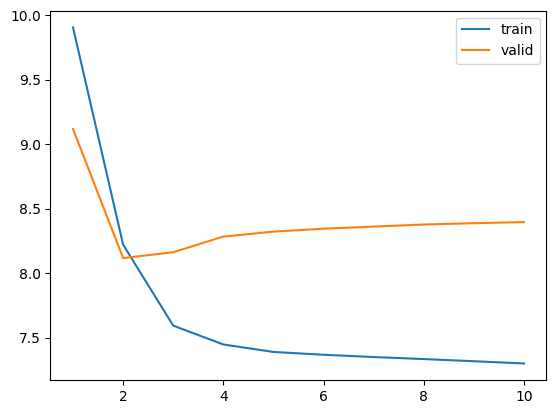

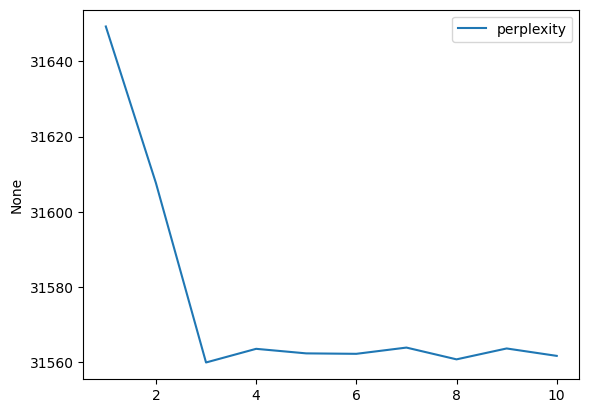

In [ ]:
history, pplHistory = trainModel(model4, lr=0.003, epochs=10)
showResults(history, pplHistory)

3-Con el modelo que les haya resultado mejor, realizar algunas pruebas de generación de secuencias utilizando greedy search, beam search determinista y beam search estocástico (aquí pueden incluso variar la temperatura).

**Utilidades para probar el modelo**

In [29]:
best_model_folder = '/content/model2'
model2.save(best_model_folder)
!zip -r model2.zip /content/model2

In [ ]:
!unzip -q model2.zip
model2=keras.saving.load_model("model2")

In [31]:
def encode_pad(tokenizer, text, max_length):
  encoded = tokenizer.texts_to_sequences([text])[0]
  return pad_sequences([encoded], maxlen=max_length, padding='pre')

def decode(tokenizer, sequence):
  return tokenizer.sequences_to_texts([sequence])

In [32]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
  """
  Exec model sequence prediction

  Args:
      model (keras): modelo entrenado
      tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
      seed_text (string): texto de entrada (input_seq)
      max_length (int): máxima longitud de la sequencia de entrada
      n_words (int): números de palabras a agregar a la sequencia de entrada
  returns:
      output_text (string): sentencia con las "n_words" agregadas
  """
  if len(seed_text) > max_length:
    raise OverflowError()

  output_text = seed_text

  for _ in range(n_words):
    y_hat = model.predict(encode_pad(tokenizer, output_text, max_length), verbose=0).argmax(axis=-1)
    word_index = tokenizer.word_index
    out_word = list(word_index.keys())[list(word_index.values()).index(y_hat)]
    output_text += ' ' + out_word

  return output_text

In [41]:
from scipy.special import softmax

def select_candidates(pred, num_beams, vocab_size, history_probs,
                      history_tokens, temp=1, s_type='determ'):

  pred_large = []

  for idx, pp in enumerate(pred):
    pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

  pred_large = np.array(pred_large)

  if s_type=='determ':
    # Beam Search determinista
    idx_select = np.argsort(pred_large)[::-1][:num_beams]
  elif s_type=='rnd':
    # Beam Search con muestreo
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp))
  else:
    raise TypeError()

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T), axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model, tokenizer, seed_text, max_length, n_words, n_beams, temp=1, s_type='determ'):
    encoded = encode_pad(tokenizer, seed_text, max_length)
    y_hat = np.squeeze(model.predict(encoded, verbose=0))

    vocab_size = y_hat.shape[0]

    history_probs = [0]*n_beams
    history_tokens = [encoded[0]]*n_beams

    # select n_beams candidates
    history_probs, history_tokens = \
      select_candidates([y_hat], n_beams, vocab_size, history_probs, history_tokens, temp, s_type)

    # beam search loop
    for i in range(n_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update, verbose=0))

        preds.append(y_hat)

      history_probs, history_tokens = \
        select_candidates(preds, n_beams, vocab_size, history_probs, history_tokens, temp, s_type)

    return history_tokens

In [50]:
test_inputs=['El señor le dijo a sus',
             'Jesus vino con',
             'El pan y el cuerpo']

n_words=5

**Generación de secuencias con estrategia Greedy Serach**

In [51]:
for test_input in test_inputs:
  print(generate_seq(model2, bible_tokenizer, test_input, max_length=max_context_size, n_words=n_words))

El señor le dijo a sus de de de de de
Jesus vino con de de de de de
El pan y el cuerpo de de de de de


**Generación de secuencias con estrategia Beam Search determinista**

In [56]:
for test_input in test_inputs:
  salidas = beam_search(model2, bible_tokenizer, test_input,
                        max_length=max_context_size, n_words=n_words,
                        n_beams=3, s_type='determ')
  for salida in salidas:
    print(decode(bible_tokenizer, salida)[0])

el señor le dijo a sus de de de de de
el señor le dijo a sus de de de de que
el señor le dijo a sus de de de de y
jesus vino con de de de de de
jesus vino con de de de de que
jesus vino con de de de de y
el pan y el cuerpo de de de de de
el pan y el cuerpo de de de de que
el pan y el cuerpo de de de de y


**Generación de secuencias con estrategia Beam Search estocástico**

In [54]:
for test_input in test_inputs:
  salidas = beam_search(model2, bible_tokenizer, test_input,
                        max_length=max_context_size, n_words=n_words,
                        n_beams=3, temp=3, s_type='rnd')
  for salida in salidas:
    print(decode(bible_tokenizer, salida)[0])

el señor le dijo a sus israelita “¡aquí mayoría piedras ¡pero
el señor le dijo a sus israelita “¡aquí mayoría tronco avisarles
el señor le dijo a sus israelita “¡aquí mayoría tronco profetizan
jesus vino con apague guiso parientes gente delantales
jesus vino con apague guiso parientes gente alas
jesus vino con apague guiso parientes idolatría astutamente
el pan y el cuerpo éufrates hogar pretoriana—sabe servirle diferente
el pan y el cuerpo éufrates hogar pretoriana—sabe bendiciendo restaura
el pan y el cuerpo éufrates hogar amontonándose deben tinajas


In [58]:
for test_input in test_inputs:
  salidas = beam_search(model2, bible_tokenizer, test_input,
                        max_length=max_context_size, n_words=n_words,
                        n_beams=3, temp=8, s_type='rnd')
  for salida in salidas:
    print(decode(bible_tokenizer, salida)[0])

el señor le dijo a sus disponemos curtidos siguió multiplicaste anotado
el señor le dijo a sus disponemos curtidos siguió multiplicaste bifurque
el señor le dijo a sus disponemos curtidos siguió multiplicaste cambiaré
jesus vino con para majestuosa restaurado andrés pesca
jesus vino con para majestuosa trajo maldición consagración
jesus vino con para majestuosa trajo maldición tocados
el pan y el cuerpo arriesgado mundo causando “saulo “escúchenme
el pan y el cuerpo arriesgado mundo causando digno permitiera
el pan y el cuerpo arriesgado mundo causando digno gloria”


## Conclusiones generales

Se pudieron observar distintos comportamientos durante el desarrollo de este desafío.

Por un lado, todos los modelos entrenados, durante el entrenamiento, mostraron un comportamiento de **sobreajuste**. En muy pocas epochs, se vio que la pérdida de train se hacía mucho más chica que la pérdida de validación. Aún con modelos muy simplificados, modificados para evitar este comportamiento, se vio esta situación.

Por otro lado, también se vio que la perplejidad, en todos los casos, presentó un comportamiento monótono decreciente. Lamentablemente, por cuestiones de tiempo, no pude agregar el análisis de esta métrica para los datos de entrenamiento. Este creo que puede ser un trabajo interesante a futuro.

Los resultados muestran lo que la métrica nos adelantaba: no se llegó a un buen modelo. Las predicciones realizas partiendo desde texto semilla, no fueron las esperedas. Fundamentalmente porque el texto generado no tiene sentido.

Por último, se probaron dos temperaturas distintas para el algoritmo de Beam Search no determinístico, y si bien hay diferencia entre lo generado para cada configuración, debido a que el texto generado no encierra un sentido visible, se hace difícil hacer una comparación conceptual.